# Домашнє завдання до модуля «Класифікація зображень»

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import copy
import random
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns
import os
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion() # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
import zipfile

# Підключення Google Диску для доступу до архіву з даними
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/IntelImageClassification.zip'

# Розпакуємо архів локально на сервері Colab
extract_path = '/content/IntelImageClassification'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Архів розпаковано локально на сервері Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Архів розпаковано локально на сервері Colab


## Підготовка даних

In [3]:
# Аугментація та нормалізація даних
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Завантаження даних
data_dir = '/content/IntelImageClassification'

train_data = datasets.ImageFolder(os.path.join(data_dir, 'seg_train', 'seg_train'), transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'seg_test', 'seg_test'), transform=data_transforms['test'])

In [5]:
# Розділяємо дані: 80% для тренування, 20% для валідації
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [6]:
# Інформація про набори даних
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"Розмір наборів даних: {dataset_sizes}")

Розмір наборів даних: {'train': 11227, 'val': 2807, 'test': 3000}


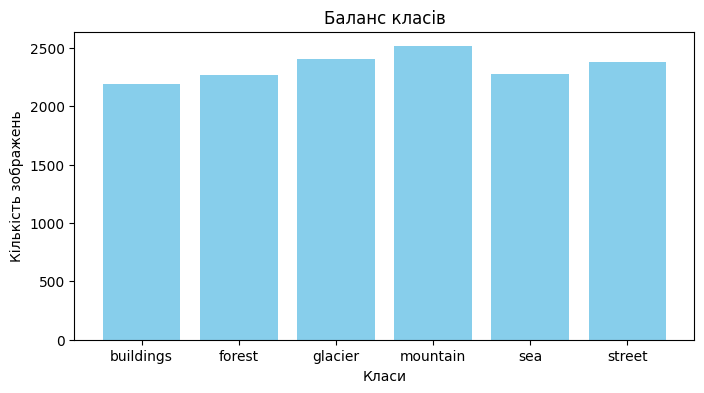

In [7]:
# Перевіряємо баланс класів
class_names = train_data.classes
class_counts = {class_name: 0 for class_name in class_names}
for _, label in train_data.samples:
    class_counts[class_names[label]] += 1
class_counts_list = [class_counts[class_name] for class_name in class_names]

plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts_list, color='skyblue')
plt.xlabel('Класи')
plt.ylabel('Кількість зображень')
plt.title('Баланс класів')
plt.show()

In [8]:
# Створення лоадерів
batch_size = 32

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size),
    'test': DataLoader(test_dataset, batch_size=batch_size)
}

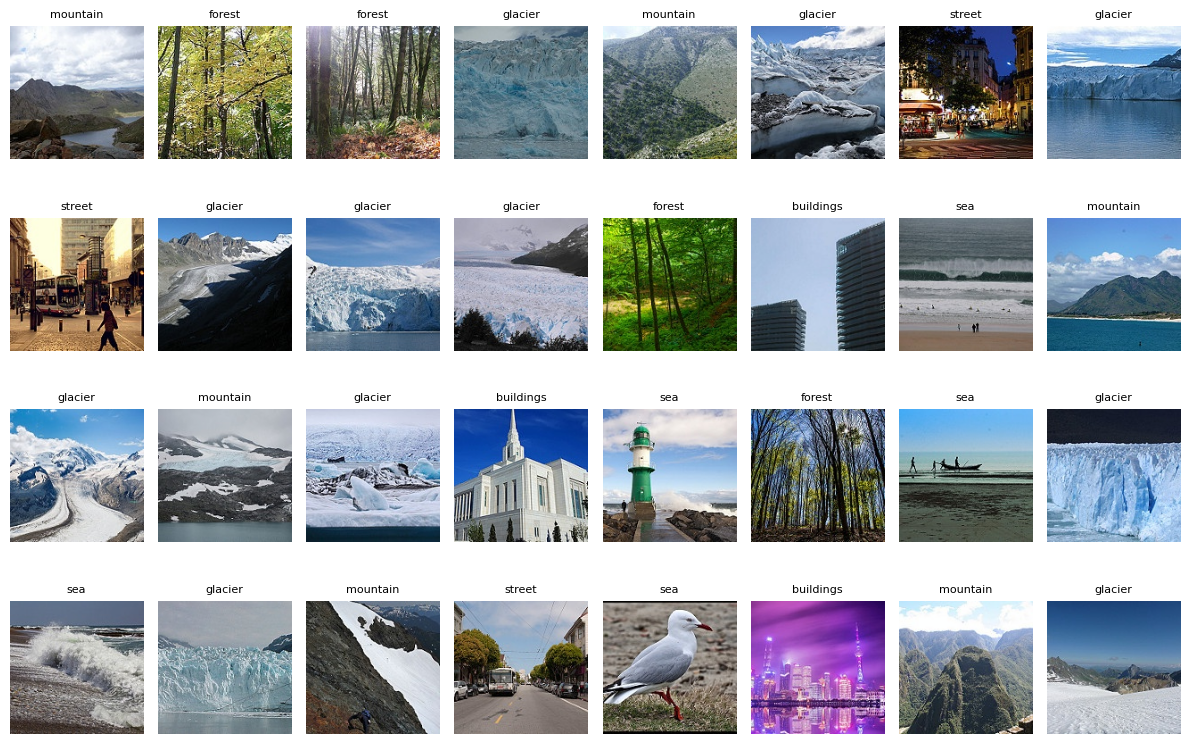

In [9]:
# Візуалізуємо батч даних із тренувального набору

# Функція для відображення прикладів
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Функція для візуалізації батчу даних
def visualize_batch(inputs, classes, class_names, num_images=batch_size):
    plt.figure(figsize=(12, 8))
    inputs = inputs[:num_images]
    classes = classes[:num_images]

    for i in range(num_images):
        ax = plt.subplot(4, 8, i + 1)
        imshow(inputs[i])
        ax.set_title(class_names[classes[i]], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
visualize_batch(inputs, classes, class_names)

## Створення моделі. Transfer Learning

In [10]:
# Завантаження моделі
model_ft = models.resnet50(pretrained=True)

# Заморожування всіх шарів, крім останнього
for param in model_ft.parameters():
    param.requires_grad = False

# Модифікація останнього шару для 6 класів
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Переміщення моделі на GPU, якщо він доступний
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

## Визначення функції втрат та оптимізатора

In [11]:
# Функція втрат. Для задачі класифікації з кількома класами найкраще підходить функція втрат CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()

# Оптимізатор. Для оптимізації обираємо Adam, оскільки він автоматично регулює параметри і добре підходить для великих моделей на великих даних.
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

## Навчання моделі

In [12]:
# Списки для зберігання втрат і точності
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Функція для навчання моделі
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Кожна епоха має тренувальну та валідаційну фазу
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Проходимося по даних
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Очищаємо градієнти
                    optimizer.zero_grad()

                    # Прямий прохід (тільки для тренувальної фази)
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Зворотний прохід та оптимізація (тільки для тренувальної фази)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Статистика втрат та кількості правильних передбачень
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Зберігаємо втрати і точність для побудови графіків
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_acc.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_acc.append(epoch_acc.item())

                # Якщо на валідаційній фазі точність краща, зберігаємо модель
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Навчання завершено за {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Найкраща валідаційна точність: {best_acc:4f}')

        # Завантажуємо найкращі ваги моделі
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [13]:
# Тренуємо модель
model_ft = train_model(model_ft, criterion, optimizer_ft)

Epoch 1/5
----------
train Loss: 0.4939 Acc: 0.8261
val Loss: 0.3000 Acc: 0.8931

Epoch 2/5
----------
train Loss: 0.3448 Acc: 0.8748
val Loss: 0.2982 Acc: 0.8917

Epoch 3/5
----------
train Loss: 0.3117 Acc: 0.8885
val Loss: 0.3061 Acc: 0.8839

Epoch 4/5
----------
train Loss: 0.3057 Acc: 0.8880
val Loss: 0.2528 Acc: 0.9120

Epoch 5/5
----------
train Loss: 0.2875 Acc: 0.8943
val Loss: 0.2678 Acc: 0.9017

Навчання завершено за 161m 56s
Найкраща валідаційна точність: 0.912006


## Оцінка моделі

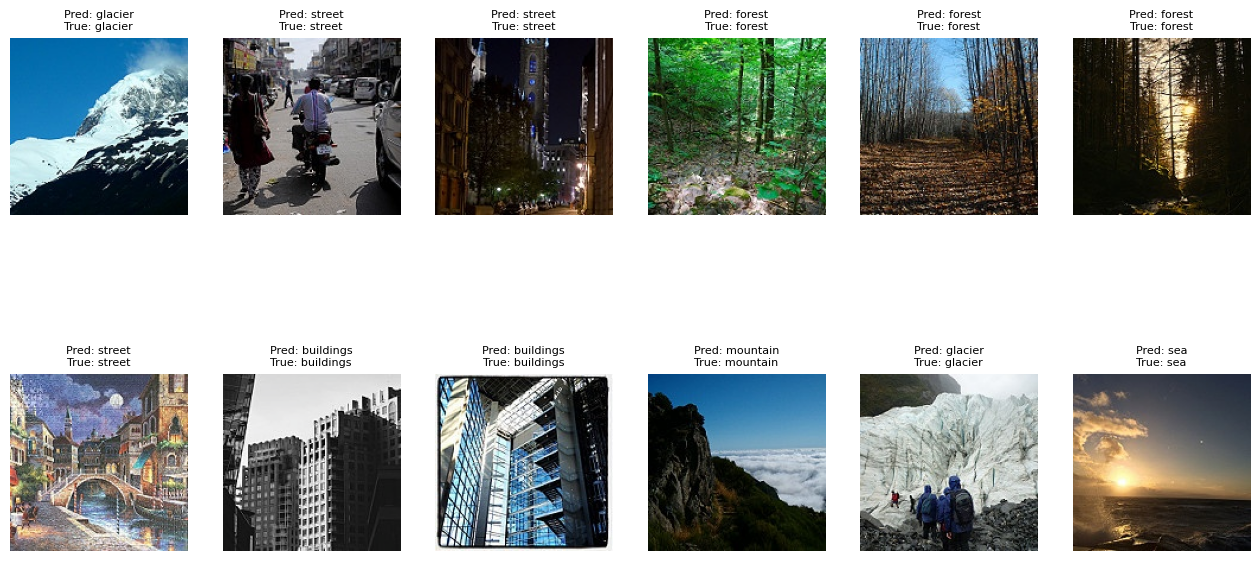

In [14]:
# Візуалізація передбачень моделі на тестовому наборі

def visualize_random_images(model, dataloader, num_images=12):
    model.eval()
    fig = plt.figure(figsize=(16, 8))

    all_images = []
    all_labels = []
    all_preds = []

    # Проходимося по всьому датасету і зберігаємо всі зображення та передбачення
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_images.extend(inputs.cpu().data)
            all_labels.extend(labels.cpu().data)
            all_preds.extend(preds.cpu().data)

    # Вибираємо випадкові індекси
    random_indices = random.sample(range(len(all_images)), num_images)

    # Відображаємо випадкові зображення
    for i, idx in enumerate(random_indices):
        ax = plt.subplot(2, 6, i + 1)
        ax.axis('off')
        imshow(all_images[idx])
        ax.set_title(f'Pred: {class_names[all_preds[idx]]}\nTrue: {class_names[all_labels[idx]]}', fontsize=8)

    plt.show()

visualize_random_images(model_ft, dataloaders['test'])

In [15]:
# Оцінка моделі
model_ft.eval()
all_preds = []
all_labels = []

# Проходимося по всіх тестових даних
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Обчислюємо Accuracy. Для задачі класифікації (6 класів) точність може бути достатньою, бо класи збалансовані
acc = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {acc:.4f}')

# Виводимо F1-Score та інші метрики, щоб оцінити здатність моделі коректно передбачати різні класи
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1-score: {weighted_f1:.4f}')
print(classification_report(all_labels, all_preds, target_names=class_names))

Accuracy: 0.8977
F1-score: 0.8970
              precision    recall  f1-score   support

   buildings       0.94      0.87      0.90       437
      forest       0.98      0.99      0.99       474
     glacier       0.85      0.81      0.83       553
    mountain       0.84      0.83      0.83       525
         sea       0.90      0.95      0.93       510
      street       0.89      0.94      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



## Аналіз результатів

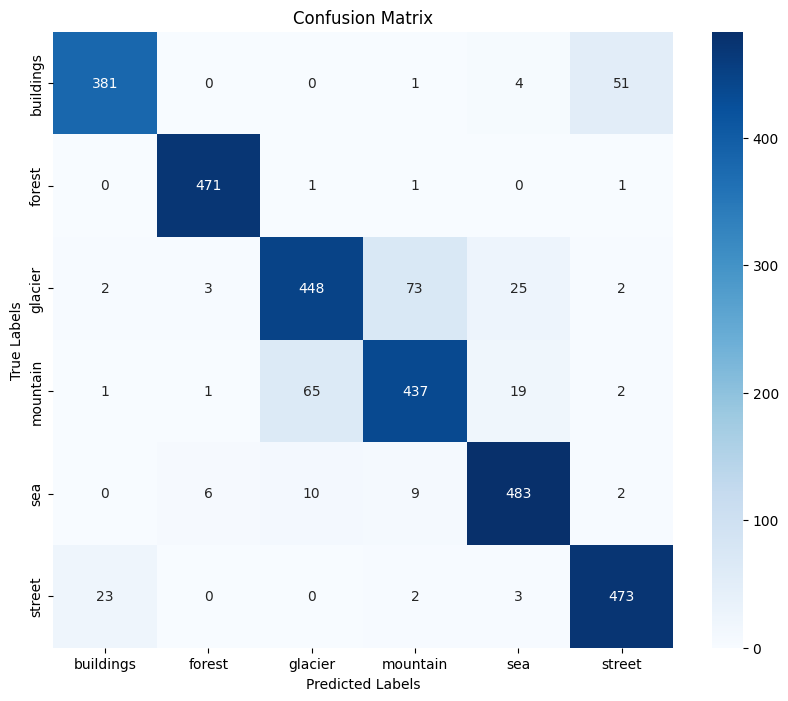

In [16]:
# Обчислюємо матрицю помилок
conf_matrix = confusion_matrix(all_labels, all_preds)

# Візуалізуємо матрицю помилок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

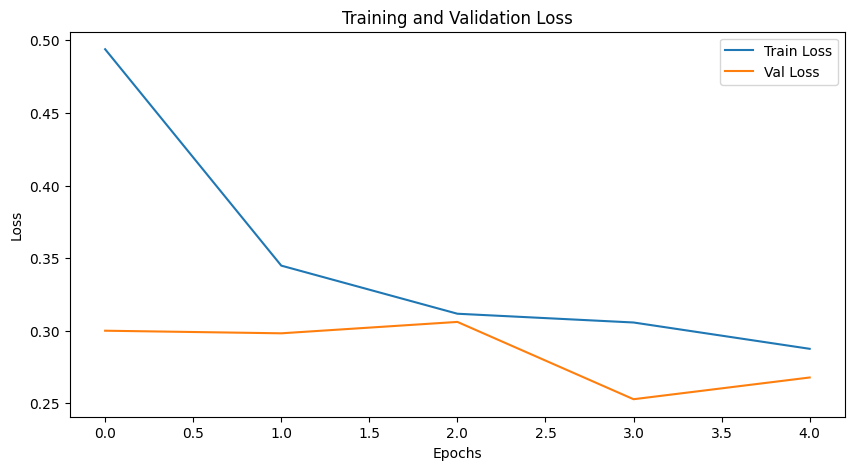

In [17]:
# Візуалізуємо криві навчання Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

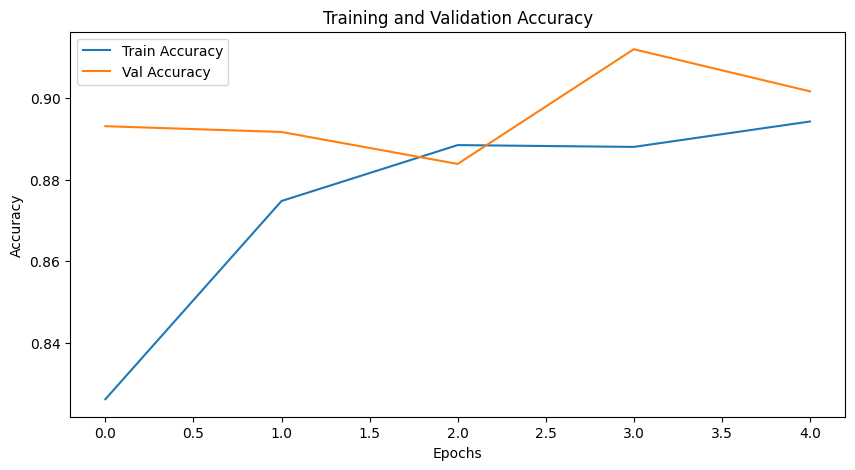

In [18]:
# Візуалізуємо криві навчання Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Висновки

#### Аналіз моделі та метрик

Модель ResNet50 змогла добре узагальнити навчання і показала досить хорошу точність на тестовому наборі даних:

**Accuracy: 89.77%**<br>
**F1-score: 89.70%**

Аналізуючи **Confusion Matrix**, можна сказати, що модель має деякі труднощі з класифікацією класів "glacier" і "mountain". Класи "forest", "sea" та "street" демонструють дуже високі результати, з майже безпомилковими класифікаціями.

**Криві навчання Loss** показують стабільне зменшення, що вказує на добре навчання без сильного перенавчання. Проте можна спостерігати невелике зростання валідаційної втрати після третьої епохи, що може бути ознакою початку перенавчання.

**Криві навчання Accuracy:** валідаційна точність стабільно зростає до 91.2%, що є добрим результатом.

#### Аналіз помилок та оптимізації моделі

Я намагалася покращити результати шляхом багатьох змін:
- змінювала моделі (ResNet18, ResNet50, densenet121, inception_v3)
- заморожувала всі шари, окрім останього одного, двух, трьох
- експериментувала з аугментацією та трансформацією даних
- змінювала швидкість навчання lr
- експериментувала з з кількістю епох та batch size.

Чому, на мою думку, модель не досягла очікуваних показників?

- розмір зображень 150x150 може бути не оптимальним для моделей, які краще працюють з більшими зображеннями
- дуже базові аугментації: коли я збільшувала їх кількість та використовувала більш складні перетворення, модель погіршувала свої результати (скоріш за все, все той же розмір зображень не дозволяє використовувати більше)
- найбільше помилок було між класами "glacier" та "mountain". Зображення цих категорій мають схожі риси, такі як сніг та гірський ландшафт. Це схожі текстури та особливості зображень, які модель важко розрізняє. Також категорії "buildings" і "street" мають деякі труднощі з класифікацією, коли кадр захоплює частину будівлі поряд із вулицею.

Ідеї щодо оптимізації:

Однозначно покращення даних. Якщо розмір зображень буде значно більший, вони відображатимуть більше деталей, які модель зможе ідентифікувати для покращення точності. Також, можливо, використання іншої моделі, яка оптимально працює з маленькими зображеннями.